# Genetic Algorithm for feature selection

A XGBoosting regression model will be build for modeling the pricing. Therefore, the feature selection process uses an instance of XGboost regressor to go through different rounds in the GA algorithm and get the most predictive variables. 





## Libraries

In [ ]:
%reload_ext autoreload
%autoreload 2

# visualisation and data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 200)


# system and files managment
import os
import sys
import pickle
import ast
import collections

# model splits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# model
import xgboost as xg

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# modules added to system path
path_tools = os.path.abspath(r'/tools')
sys.path.extend([path_tools])

In [ ]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/tools']

In [ ]:
import tools.feature_selection as fselec
import tools.exploring_tools as mtools

## Support functions

In [ ]:
def best_in_gene(best_scores):
    plt.plot(best_scores)
    plt.xlabel("Iterations")
    plt.ylabel("Fitness metrix")


def bests_chromos_coparison(bests_chromos, best_scores):
    """
    Comparing the best chromosomes to look for degenerated clases.

    :param bests_chromos: list with the chromosomes as numpy arrays
    :param best_scores: list with the score of each chromosome

    :return: list of tuples with the comparison and score:
    (index, pair of index compared, result of comparison,
    score of chromosome in the index)
    """
    list_compare = []
    for chromosome_idx in range(len(bests_chromos)):
        next_idx = (1 + chromosome_idx)%len(bests_chromos)
        list_compare.append((chromosome_idx,
                             "c{}-{}".format(chromosome_idx, next_idx),
                            (bests_chromos[chromosome_idx] == bests_chromos[next_idx]). all(),
                            "sc-{}".format(chromosome_idx), best_scores[chromosome_idx],
                             "# features {}".format(np.sum(bests_chromos[chromosome_idx]))))
    return list_compare

In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

## Loading data set and list of variables

In [ ]:
df = pd.read_pickle('extended_data_set.pickle')

In [ ]:
var_set_1 = [
'price_log',
'latitude',
'longitude',
'accommodates',
'bedrooms',
'beds',
'minimum_nights',
'maximum_nights',
'minimum_minimum_nights',
'maximum_minimum_nights',
'minimum_maximum_nights',
'maximum_maximum_nights',
'minimum_nights_avg_ntm',
'maximum_nights_avg_ntm',
'has_availability',
'availability_30',
'availability_60',
'availability_90',
'availability_365',
'bathrooms_shared',
'number_amenities',
'room_type_num']

var_amenties = ['wifi',
'heating',
'essentials',
'kitchen',
'smoke_alarm',
'washer',
'hangers',
'iron',
'tv',
'hair_dryer',
'shampoo',
'dedicated_workspace',
'carbon_monoxide_alarm',
'hot_water',
'dryer',
'refrigerator',
'dishes_and_silverware',
'cooking_basics',
'oven',
'bed_linens',
'microwave',
'stove',
'fire_extinguisher',
'first_aid_kit',
'private_entrance',
'dishwasher',
'coffee_maker',
'long_term_stays_allowed',
'elevator',
'free_parking_on_premises',
'extra_pillows_and_blankets',
'lock_on_bedroom_door',
'host_greets_you',
'cable_tv',
'luggage_dropoff_allowed',
'patio_or_balcony',
'garden_or_backyard',
'breakfast',
'paid_parking_off_premises',
'lockbox',
'free_street_parking',
'bathtub']

## Dividig data into Train/Test

In [ ]:
y = df['price_log'].values

In [ ]:
X = df[var_set_1[1:] + var_amenties].copy()

In [ ]:
X.head()

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,bathrooms_shared,number_amenities,room_type_num,wifi,heating,essentials,kitchen,smoke_alarm,washer,hangers,iron,tv,hair_dryer,shampoo,dedicated_workspace,carbon_monoxide_alarm,hot_water,dryer,refrigerator,dishes_and_silverware,cooking_basics,oven,bed_linens,microwave,stove,fire_extinguisher,first_aid_kit,private_entrance,dishwasher,coffee_maker,long_term_stays_allowed,elevator,free_parking_on_premises,extra_pillows_and_blankets,lock_on_bedroom_door,host_greets_you,cable_tv,luggage_dropoff_allowed,patio_or_balcony,garden_or_backyard,breakfast,paid_parking_off_premises,lockbox,free_street_parking,bathtub
0,51.46225,-0.11732,4,1.0,3.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,1.0,3,33,63,338,0.0,28,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,51.56802,-0.11121,2,1.0,0.0,1,29,1.0,1.0,29.0,29.0,1.0,29.0,1.0,30,60,90,365,1.0,41,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
2,51.48796,-0.16898,2,1.0,1.0,10,50,10.0,10.0,50.0,50.0,10.0,50.0,1.0,29,59,62,189,0.0,24,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51.52195,-0.14094,6,3.0,3.0,4,365,4.0,4.0,365.0,365.0,4.0,365.0,1.0,16,16,16,231,0.0,27,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,51.47935,-0.19743,2,1.0,1.0,3,21,3.0,3.0,21.0,21.0,3.0,21.0,1.0,29,59,89,364,0.0,16,2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

In [ ]:
y_train

array([3.33220451, 4.15888308, 4.31748811, ..., 4.38202663, 3.55534806,
       3.09104245])

In [ ]:
X_train.shape

(60891, 63)

# Genetic Algorithm feature selection rounds

## 1st Round

In [ ]:
# Instantiation 
clf = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
# set importance type to gain rather than default 'split'
clf.set_params(importance_type='gain')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
bests_chromos_hlf_4, best_scores_hlf_4 = fselec.generations_v4(size=200,
                                                              n_feat=X_train.shape[1],
                                                              metric=RMSE,
                                                              clf=clf,
                                                              n_parents=100,
                                                              mutation_rate=0.2, 
                                                              n_generations=10,
                                                              X_train=X_train,
                                                              y_train=y_train,
                                                              percent_not_feat=0.7,
                                                              seed=42,
                                                              random_state_fit=42,
                                                              classification=False,
                                                              early_stop_ths=0.005,
                                                              early_stop_falg=False)

[0.43307517917836275, 0.43434674927713246]
[0.4237627970695444, 0.4320519494521144]
[0.4141127255990032, 0.41929699906326096]
[0.41181957631484734, 0.4141127255990032]
[0.41181957631484734, 0.4123259546832378]
[0.41181957631484734, 0.4123259546832378]
[0.41181957631484734, 0.4123259546832378]
[0.40985388120645627, 0.4109103727078686]
[0.40985388120645627, 0.41036087212493744]
[0.40985388120645627, 0.41036087212493744]


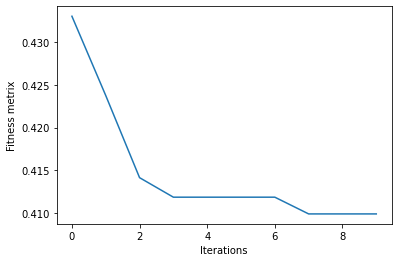

In [ ]:
best_in_gene(best_scores_hlf_4)

In [ ]:
list_compare_hlf_4 = bests_chromos_coparison(bests_chromos=bests_chromos_hlf_4, 
                                             best_scores=best_scores_hlf_4)

In [ ]:
list_compare_hlf_4

[(0, 'c0-1', False, 'sc-0', 0.43307517917836275, '# features 19'),
 (1, 'c1-2', False, 'sc-1', 0.4237627970695444, '# features 27'),
 (2, 'c2-3', False, 'sc-2', 0.4141127255990032, '# features 25'),
 (3, 'c3-4', True, 'sc-3', 0.41181957631484734, '# features 34'),
 (4, 'c4-5', True, 'sc-4', 0.41181957631484734, '# features 34'),
 (5, 'c5-6', True, 'sc-5', 0.41181957631484734, '# features 34'),
 (6, 'c6-7', False, 'sc-6', 0.41181957631484734, '# features 34'),
 (7, 'c7-8', True, 'sc-7', 0.40985388120645627, '# features 33'),
 (8, 'c8-9', True, 'sc-8', 0.40985388120645627, '# features 33'),
 (9, 'c9-0', False, 'sc-9', 0.40985388120645627, '# features 33')]

In [ ]:
print(bests_chromos_hlf_4[-1])
X_train.iloc[:,bests_chromos_hlf_4[-1]].columns

[ True  True  True  True False False  True False False False False  True
 False  True  True  True False False  True  True  True  True  True False
  True False False False False  True  True  True  True False  True False
 False  True  True False False  True False  True False  True  True  True
 False  True False  True False  True  True False  True False False  True
 False False False]


Index(['latitude', 'longitude', 'accommodates', 'bedrooms', 'maximum_nights',
       'minimum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'bathrooms_shared', 'number_amenities',
       'room_type_num', 'wifi', 'heating', 'kitchen', 'tv', 'hair_dryer',
       'shampoo', 'dedicated_workspace', 'hot_water', 'dishes_and_silverware',
       'cooking_basics', 'microwave', 'fire_extinguisher', 'private_entrance',
       'dishwasher', 'coffee_maker', 'elevator', 'extra_pillows_and_blankets',
       'host_greets_you', 'cable_tv', 'patio_or_balcony',
       'paid_parking_off_premises'],
      dtype='object')

In [ ]:
first_round_list = ['latitude', 'longitude', 'accommodates', 'bedrooms', 'maximum_nights',
       'minimum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'bathrooms_shared', 'number_amenities',
       'room_type_num', 'wifi', 'heating', 'kitchen', 'tv', 'hair_dryer',
       'shampoo', 'dedicated_workspace', 'hot_water', 'dishes_and_silverware',
       'cooking_basics', 'microwave', 'fire_extinguisher', 'private_entrance',
       'dishwasher', 'coffee_maker', 'elevator', 'extra_pillows_and_blankets',
       'host_greets_you', 'cable_tv', 'patio_or_balcony',
       'paid_parking_off_premises']

In [ ]:
X_train_01 = X_train[first_round_list].copy()

In [ ]:
clf_01 = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
clf_01.fit(X_train[first_round_list], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

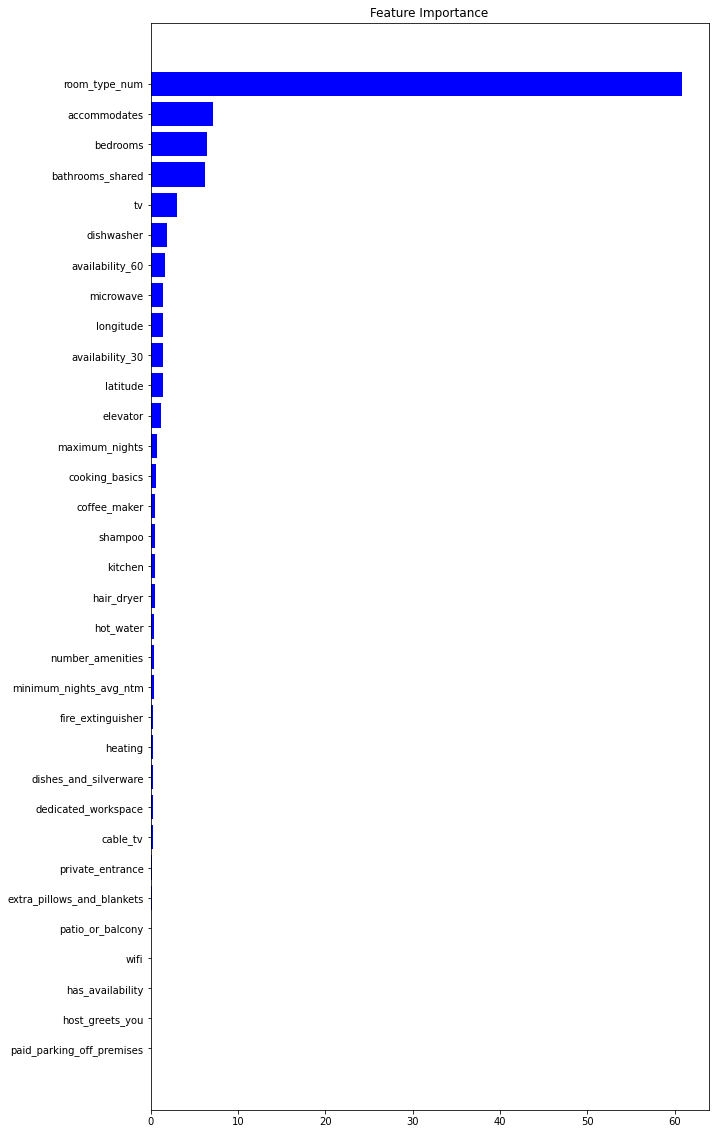

In [ ]:
df_feature_importance_01 = fselec.feature_importance(model=clf_01, 
                                                     model_type='Uncalibrated',
                                                     feature_list=first_round_list)                

In [ ]:
df_feature_importance_01

,Feature_importance%
room_type_num,60.822701
accommodates,7.136811
bedrooms,6.401356
bathrooms_shared,6.218227
tv,3.026444
dishwasher,1.839549
availability_60,1.665193
microwave,1.476967
longitude,1.411121
availability_30,1.389183


In [ ]:
X_test_01 = X_test[first_round_list].copy()

In [ ]:
# Predict the model 
pred_1 = clf_01.predict(X_test_01) 
pred_1

array([4.706099 , 4.0292974, 3.9971528, ..., 3.5223298, 3.9327188,
       3.580825 ], dtype=float32)

In [ ]:
# evaluating prediction
rmse_1 = RMSE(y_test, pred_1)
rmse_1

0.40512962256023827

## 2nd Round

In [ ]:
# best columns from firs roound
bests_chromos_hlf_5, best_scores_hlf_5 = fselec.generations_v4(size=200,
                                                              n_feat=len(first_round_list),
                                                              metric=RMSE,
                                                              clf=clf,
                                                              n_parents=100,
                                                              mutation_rate=0.2, 
                                                              n_generations=10,
                                                              X_train=X_train[first_round_list],
                                                              y_train=y_train,
                                                              percent_not_feat=0.8,
                                                              seed=42,
                                                              random_state_fit=42,
                                                              classification=False,
                                                              early_stop_ths=0.005,
                                                              early_stop_falg=False)

[0.4461544182885245, 0.45750709658296457]
[0.4298946581677378, 0.44103269050220867]
[0.41429386166228643, 0.416471567628069]
[0.41429386166228643, 0.416471567628069]
[0.41429386166228643, 0.41529905413866214]
[0.41266163188961685, 0.41271699273414697]
[0.410720243447765, 0.41266163188961685]
[0.410720243447765, 0.41201862300739633]
[0.410720243447765, 0.41201862300739633]
[0.410720243447765, 0.41119675632489394]


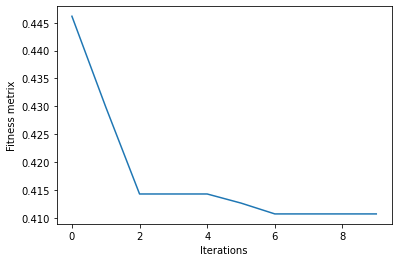

In [ ]:
best_in_gene(best_scores_hlf_5)

In [ ]:
list_compare_hlf_5 = bests_chromos_coparison(bests_chromos=bests_chromos_hlf_5, 
                                             best_scores=best_scores_hlf_5)

In [ ]:
list_compare_hlf_5

[(0, 'c0-1', False, 'sc-0', 0.4461544182885245, '# features 7'),
 (1, 'c1-2', False, 'sc-1', 0.4298946581677378, '# features 16'),
 (2, 'c2-3', True, 'sc-2', 0.41429386166228643, '# features 16'),
 (3, 'c3-4', True, 'sc-3', 0.41429386166228643, '# features 16'),
 (4, 'c4-5', False, 'sc-4', 0.41429386166228643, '# features 16'),
 (5, 'c5-6', False, 'sc-5', 0.41266163188961685, '# features 14'),
 (6, 'c6-7', True, 'sc-6', 0.410720243447765, '# features 25'),
 (7, 'c7-8', True, 'sc-7', 0.410720243447765, '# features 25'),
 (8, 'c8-9', True, 'sc-8', 0.410720243447765, '# features 25'),
 (9, 'c9-0', False, 'sc-9', 0.410720243447765, '# features 25')]

In [ ]:
print(bests_chromos_hlf_5[-1])

[ True  True  True  True  True False False  True  True  True False  True
 False  True  True  True False  True  True  True False  True  True False
  True  True  True  True False  True  True  True  True]


In [ ]:
X_train_01.iloc[:,bests_chromos_hlf_5[-1]].columns

Index(['latitude', 'longitude', 'accommodates', 'bedrooms', 'maximum_nights',
       'availability_30', 'availability_60', 'bathrooms_shared',
       'room_type_num', 'heating', 'kitchen', 'tv', 'shampoo',
       'dedicated_workspace', 'hot_water', 'cooking_basics', 'microwave',
       'private_entrance', 'dishwasher', 'coffee_maker', 'elevator',
       'host_greets_you', 'cable_tv', 'patio_or_balcony',
       'paid_parking_off_premises'],
      dtype='object')

In [ ]:
first_round_list_02 = ['latitude', 'longitude', 'accommodates', 'bedrooms', 'maximum_nights',
       'availability_30', 'availability_60', 'bathrooms_shared',
       'room_type_num', 'heating', 'kitchen', 'tv', 'shampoo',
       'dedicated_workspace', 'hot_water', 'cooking_basics', 'microwave',
       'private_entrance', 'dishwasher', 'coffee_maker', 'elevator',
       'host_greets_you', 'cable_tv', 'patio_or_balcony',
       'paid_parking_off_premises']

In [ ]:
X_train_02 = X_train_01[first_round_list_02].copy()

In [ ]:
clf_02 = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
clf_02.fit(X_train_02, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

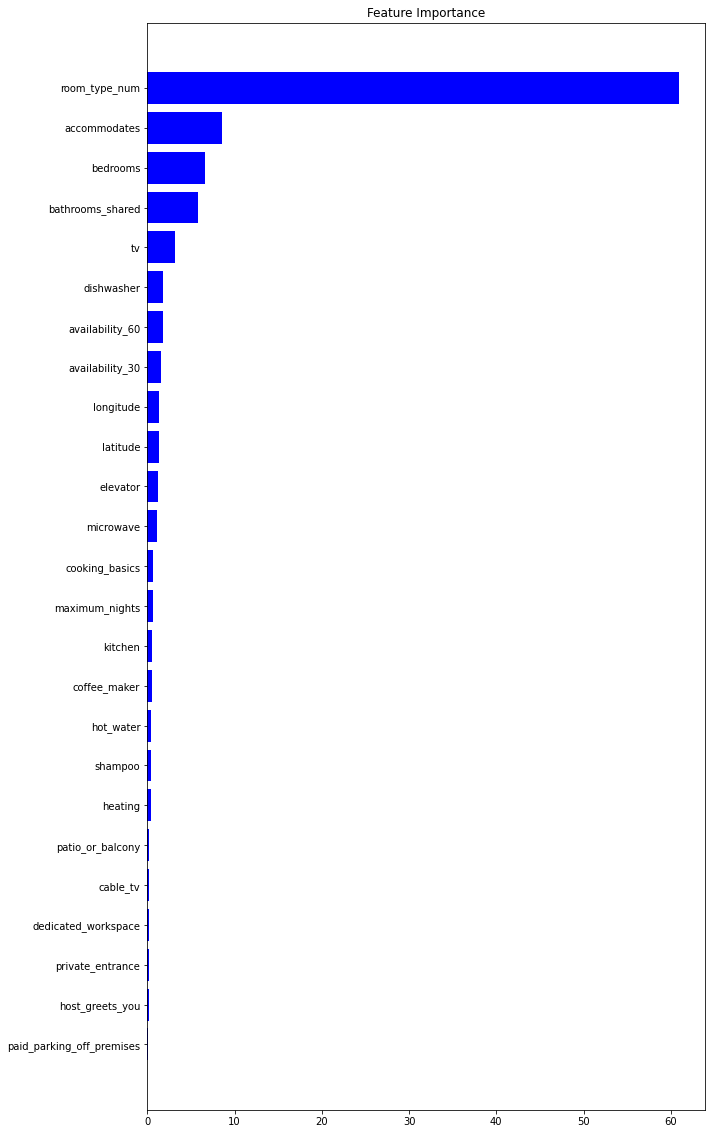

In [ ]:
df_feature_importance_02 = fselec.feature_importance(model=clf_02, 
                                                     model_type='Uncalibrated',
                                                     feature_list=first_round_list_02)                

In [ ]:
df_feature_importance_02

,Feature_importance%
room_type_num,60.915054
accommodates,8.613807
bedrooms,6.649660
bathrooms_shared,5.791234
tv,3.137387
dishwasher,1.793111
availability_60,1.753305
availability_30,1.623776
longitude,1.344454
latitude,1.335617


In [ ]:
X_test_02 = X_test_01[first_round_list_02].copy()

In [ ]:
# Predict the model 
pred_2 = clf_02.predict(X_test_02) 
pred_2

array([4.7538824, 4.0873456, 3.9877684, ..., 3.4857101, 3.9409385,
       3.6069477], dtype=float32)

In [ ]:
# evaluating prediction
rmse_2= RMSE(y_test, pred_2)
rmse_2

0.40640160394948976

## 3rd Round

In [ ]:
# best columns from firs roound
bests_chromos_hlf_6, best_scores_hlf_6 = fselec.generations_v4(size=200,
                                                              n_feat=len(first_round_list_02),
                                                              metric=RMSE,
                                                              clf=clf,
                                                              n_parents=100,
                                                              mutation_rate=0.2, 
                                                              n_generations=10,
                                                              X_train=X_train_02,
                                                              y_train=y_train,
                                                              percent_not_feat=0.8,
                                                              seed=42,
                                                              random_state_fit=42,
                                                              classification=False,
                                                              early_stop_ths=0.005,
                                                              early_stop_falg=False)

[0.45972204596964145, 0.4623239005682988]
[0.4390947076293226, 0.4391857824998006]
[0.41871771949725867, 0.4200932621187648]
[0.41871771949725867, 0.4198019406593893]
[0.4177002735072351, 0.41871771949725867]
[0.41685836019485684, 0.41704160262495216]
[0.4147216421657601, 0.4156128700064488]
[0.41213191025600926, 0.4135321383633907]
[0.41213191025600926, 0.4135321383633907]
[0.41213191025600926, 0.4135321383633907]


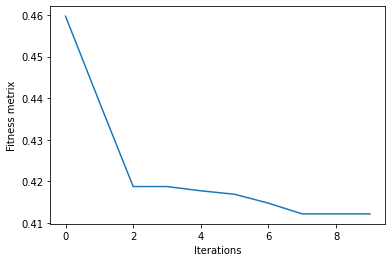

In [ ]:
best_in_gene(best_scores_hlf_6)

In [ ]:
list_compare_hlf_6 = bests_chromos_coparison(bests_chromos=bests_chromos_hlf_6, 
                                             best_scores=best_scores_hlf_6)

In [ ]:
list_compare_hlf_6

[(0, 'c0-1', False, 'sc-0', 0.45972204596964145, '# features 5'),
 (1, 'c1-2', False, 'sc-1', 0.4390947076293226, '# features 10'),
 (2, 'c2-3', True, 'sc-2', 0.41871771949725867, '# features 13'),
 (3, 'c3-4', False, 'sc-3', 0.41871771949725867, '# features 13'),
 (4, 'c4-5', False, 'sc-4', 0.4177002735072351, '# features 13'),
 (5, 'c5-6', False, 'sc-5', 0.41685836019485684, '# features 18'),
 (6, 'c6-7', False, 'sc-6', 0.4147216421657601, '# features 17'),
 (7, 'c7-8', True, 'sc-7', 0.41213191025600926, '# features 18'),
 (8, 'c8-9', True, 'sc-8', 0.41213191025600926, '# features 18'),
 (9, 'c9-0', False, 'sc-9', 0.41213191025600926, '# features 18')]

In [ ]:
print(bests_chromos_hlf_6[-1])

[ True  True  True  True  True  True  True  True  True False False  True
  True False  True  True False False  True False  True  True  True False
  True]


In [ ]:
X_train_02.iloc[:, bests_chromos_hlf_6[-1]].columns

Index(['latitude', 'longitude', 'accommodates', 'bedrooms', 'maximum_nights',
       'availability_30', 'availability_60', 'bathrooms_shared',
       'room_type_num', 'tv', 'shampoo', 'hot_water', 'cooking_basics',
       'dishwasher', 'elevator', 'host_greets_you', 'cable_tv',
       'paid_parking_off_premises'],
      dtype='object')

In [ ]:
first_round_list_03 = ['latitude', 'longitude', 'accommodates', 'bedrooms', 'maximum_nights',
       'availability_30', 'availability_60', 'bathrooms_shared',
       'room_type_num', 'tv', 'shampoo', 'hot_water', 'cooking_basics',
       'dishwasher', 'elevator', 'host_greets_you', 'cable_tv',
       'paid_parking_off_premises']

In [ ]:
X_train_03 = X_train_02.loc[:, first_round_list_03].copy()

In [ ]:
len(first_round_list_03)

18

In [ ]:
clf_03 = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
clf_03.fit(X_train_03, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

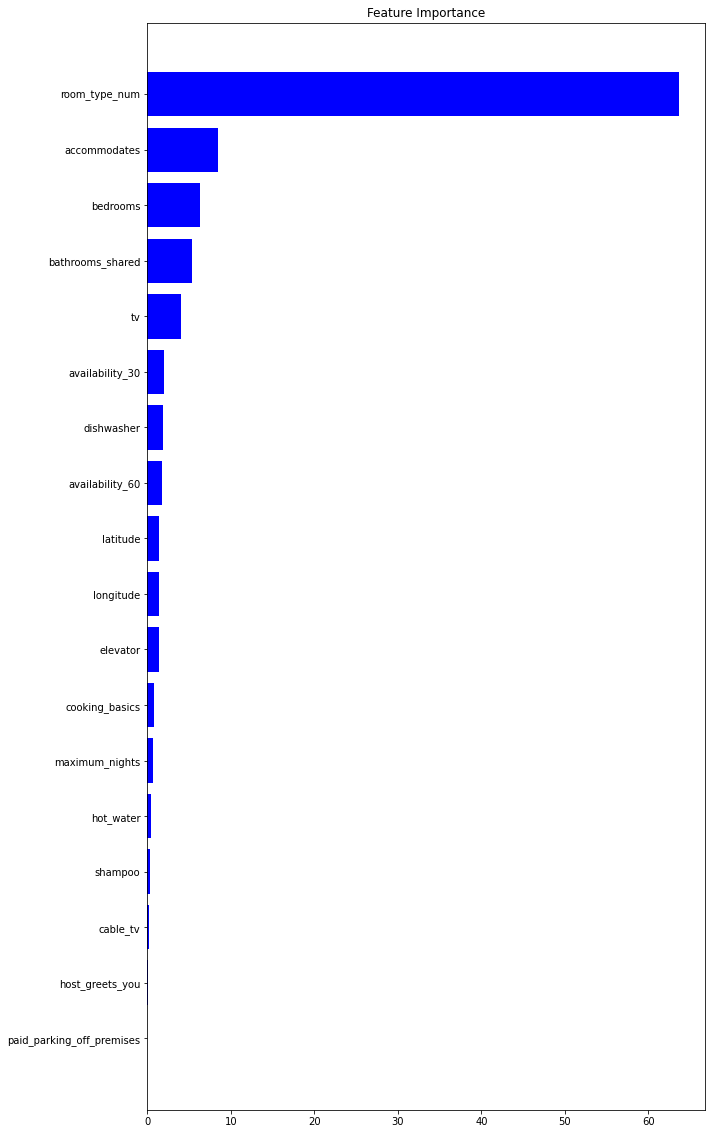

In [ ]:
df_feature_importance_03 = fselec.feature_importance(model=clf_03, 
                                                     model_type='Uncalibrated',
                                                     feature_list=first_round_list_03)                

In [ ]:
df_feature_importance_03

,Feature_importance%
room_type_num,63.646008
accommodates,8.472505
bedrooms,6.284707
bathrooms_shared,5.366036
tv,3.987548
availability_30,1.955242
dishwasher,1.894462
availability_60,1.713724
latitude,1.400090
longitude,1.365225


In [ ]:
X_test_03 = X_test_02[first_round_list_03].copy()

In [ ]:
# Predict the model 
pred_3 = clf_03.predict(X_test_03) 
pred_3

array([4.755425 , 4.060215 , 3.9383528, ..., 3.5149748, 3.9343395,
       3.6162007], dtype=float32)

In [ ]:
# evaluating prediction
rmse_3 = RMSE(y_test, pred_3)
rmse_3

0.40785734788935235

In [ ]:
# best columns from firs roound
bests_chromos_hlf_7, best_scores_hlf_7 = fselec.generations_v4(size=200,
                                                              n_feat=len(first_round_list_03),
                                                              metric=RMSE,
                                                              clf=clf,
                                                              n_parents=100,
                                                              mutation_rate=0.2, 
                                                              n_generations=10,
                                                              X_train=X_train_03,
                                                              y_train=y_train,
                                                              percent_not_feat=0.8,
                                                              seed=42,
                                                              random_state_fit=42,
                                                              classification=False,
                                                              early_stop_ths=0.005,
                                                              early_stop_falg=False)

[0.4695919440803298, 0.4696546562306318]
[0.435426440045426, 0.43720833852561153]
[0.4281497979985267, 0.4337671545176269]
[0.42259605102767334, 0.4237562251370907]
[0.42114636367879976, 0.42259605102767334]
[0.41673599726445404, 0.41999756683839456]
[0.41485331197617875, 0.415214450451906]
[0.41462702126135526, 0.41464317451633964]
[0.4141729121730931, 0.4142404587269135]
[0.4141729121730931, 0.4142404587269135]


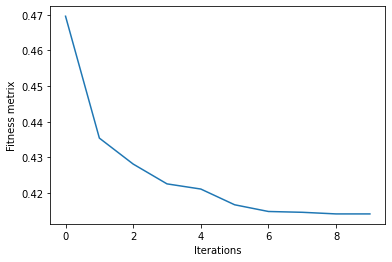

In [ ]:
best_in_gene(best_scores_hlf_7)

In [ ]:
list_compare_hlf_7 = bests_chromos_coparison(bests_chromos=bests_chromos_hlf_7, 
                                             best_scores=best_scores_hlf_7)

In [ ]:
list_compare_hlf_7

[(0, 'c0-1', False, 'sc-0', 0.4695919440803298, '# features 4'),
 (1, 'c1-2', False, 'sc-1', 0.435426440045426, '# features 10'),
 (2, 'c2-3', False, 'sc-2', 0.4281497979985267, '# features 8'),
 (3, 'c3-4', False, 'sc-3', 0.42259605102767334, '# features 11'),
 (4, 'c4-5', False, 'sc-4', 0.42114636367879976, '# features 12'),
 (5, 'c5-6', False, 'sc-5', 0.41673599726445404, '# features 10'),
 (6, 'c6-7', False, 'sc-6', 0.41485331197617875, '# features 11'),
 (7, 'c7-8', False, 'sc-7', 0.41462702126135526, '# features 13'),
 (8, 'c8-9', True, 'sc-8', 0.4141729121730931, '# features 12'),
 (9, 'c9-0', False, 'sc-9', 0.4141729121730931, '# features 12')]

In [ ]:
print(bests_chromos_hlf_7[-1])

[ True  True  True  True  True  True False  True  True  True False  True
 False  True False False  True False]


In [ ]:
select_hlf_7 = [ True, True, True ,True,  True,  True, False,  True,  True,  True, False,  True,
 False,  True, False, False,  True, False]

In [ ]:
X_train_03.iloc[:, select_hlf_7].columns

Index(['latitude', 'longitude', 'accommodates', 'bedrooms', 'maximum_nights',
       'availability_30', 'bathrooms_shared', 'room_type_num', 'tv',
       'hot_water', 'dishwasher', 'cable_tv'],
      dtype='object')

In [ ]:
first_round_list_04 = list(X_train_03.iloc[:, select_hlf_7].columns)

In [ ]:
len(first_round_list_04)

12

In [ ]:
X_train_04 = X_train_03.iloc[:, select_hlf_7].copy()

In [ ]:
clf_04 = xg.XGBRegressor(objective ='reg:squarederror', 
                        max_depth=3, 
                        n_estimators=100, 
                        random_state=0)

In [ ]:
clf_04.fit(X_train_04, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

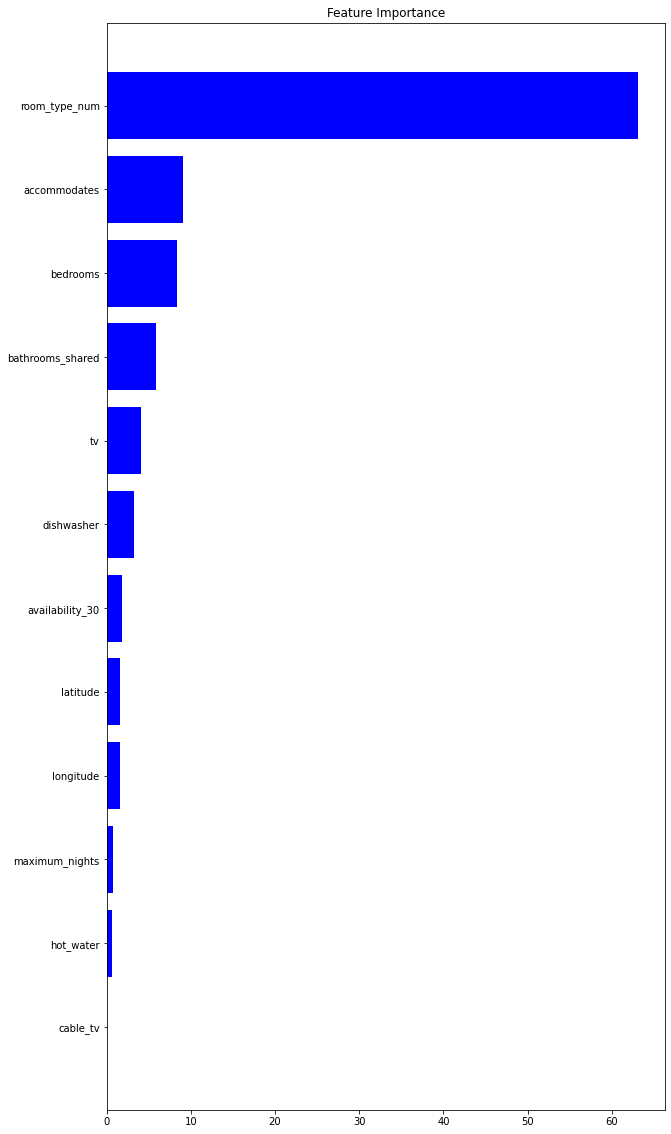

In [ ]:
df_feature_importance_04 = fselec.feature_importance(model=clf_04, 
                                                     model_type='Uncalibrated',
                                                     feature_list=first_round_list_04)                

In [ ]:
df_feature_importance_04

,Feature_importance%
room_type_num,63.133419
accommodates,9.053519
bedrooms,8.388864
bathrooms_shared,5.873417
tv,4.094971
dishwasher,3.219708
availability_30,1.831721
latitude,1.538228
longitude,1.521373
maximum_nights,0.719187


In [ ]:
X_test_04 = X_test_03[first_round_list_04].copy()

In [ ]:
# Predict the model 
pred_4 = clf_04.predict(X_test_04) 
pred_4

array([4.7807984, 4.085519 , 3.9452255, ..., 3.5450904, 3.8987665,
       3.614887 ], dtype=float32)

In [ ]:
# evaluating prediction
rmse_4 = RMSE(y_test, pred_2)
rmse_4

0.40640160394948976

In [ ]:
corr_spear_4 = df[first_round_list_04 + ['price_log']].corr(method='spearman').abs()

In [ ]:
cmap = sns.diverging_palette(250, 10, as_cmap=True)

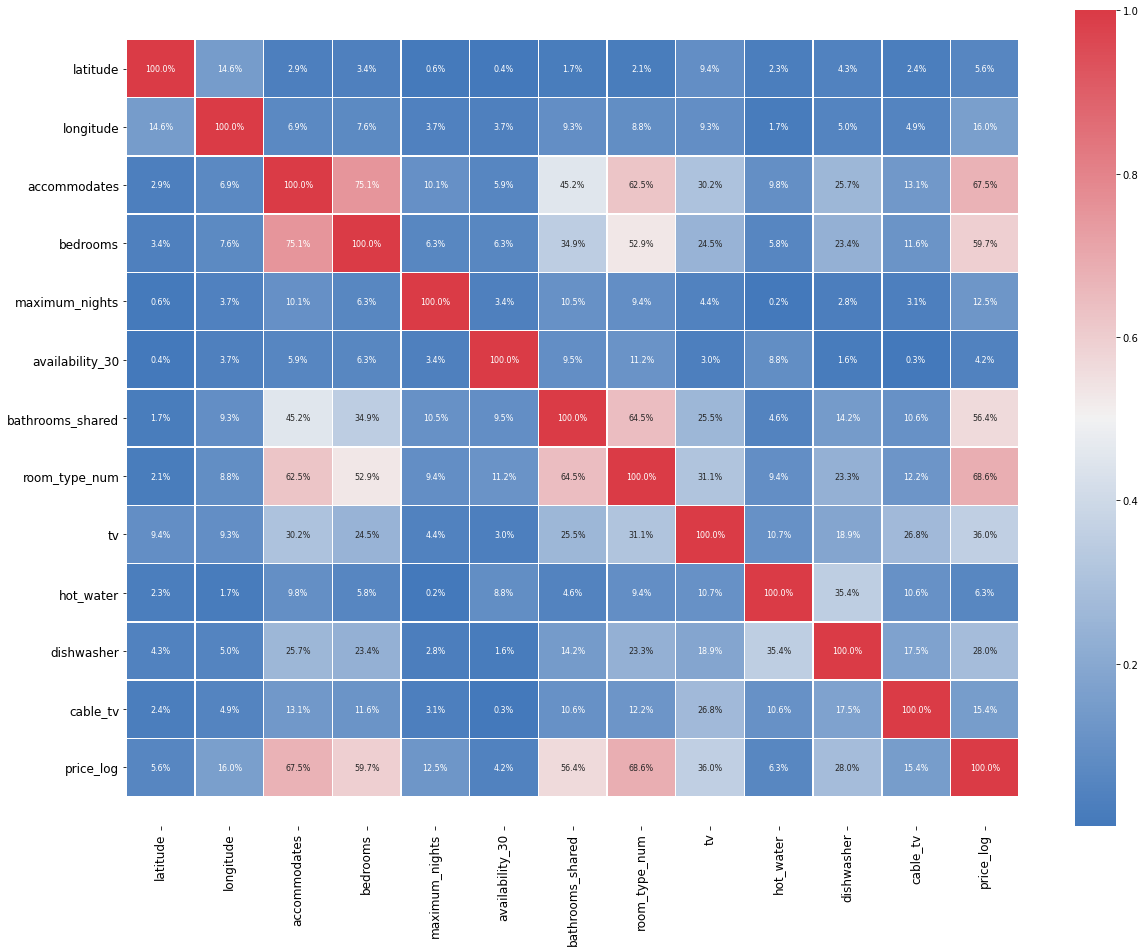

In [ ]:
mtools.heat_map_corr(corr_spear_4, cmap, square=False, annot=True)